

```
 potato disease prediction
```



### Importing the necessary libraries.


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Adding some static variables

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

Import data into tensorflow dataset object


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2154 files belonging to 3 classes.


Class names

In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

First batch image printing

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 2 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 2 0 1 0 0]


Visualize some of the images from our dataset


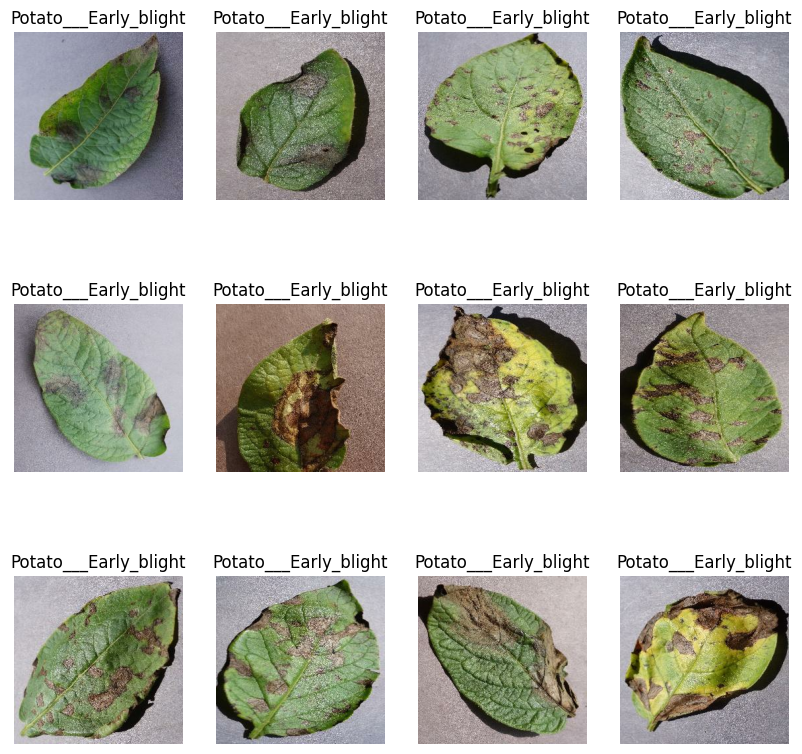

In [ ]:
# Define the class names
class_names = ["Potato___Early_blight" , "Potato___Early_blight" , "Potato___Early_blight" , ...]

# Plot the images with titles
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset

In [ ]:
len(dataset)

68

In [ ]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)


6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

Creating a Layer for Resizing and Normalization

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 31s 408ms/step - loss: 0.9200 - accuracy: 0.4884 - val_loss: 0.8788 - val_accuracy: 0.4635
Epoch 2/50
54/54 [==============================] - 17s 312ms/step - loss: 0.7163 - accuracy: 0.6464 - val_loss: 0.5492 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 16s 286ms/step - loss: 0.5053 - accuracy: 0.7801 - val_loss: 0.4485 - val_accuracy: 0.7812
Epoch 4/50
54/54 [==============================] - 15s 282ms/step - loss: 0.3964 - accuracy: 0.8229 - val_loss: 0.2625 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 15s 283ms/step - loss: 0.3093 - accuracy: 0.8791 - val_loss: 0.2424 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 16s 300ms/step - loss: 0.2709 - accuracy: 0.9010 - val_loss: 0.1285 - val_accuracy: 0.9688
Epoch 7/50
54/54 [==============================] - 16s 288ms/step - loss: 0.2254 - accuracy: 0.9236 - val_loss: 0.4243 - val_accuracy: 0.8125

In [ ]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 7s 28ms/step - loss: 0.0775 - accuracy: 0.9766


In [ ]:
scores


[0.07753638178110123, 0.9765625]

Plotting the Accuracy and Loss Curves

In [ ]:
history

In [84]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

5

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.023157455027103424,
 0.021108154207468033,
 0.017371930181980133,
 0.01002487912774086,
 0.002578773768618703]

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

KeyError: 'val_accuracy'

ValueError: x and y must have same first dimension, but have shapes (50,) and (5,)

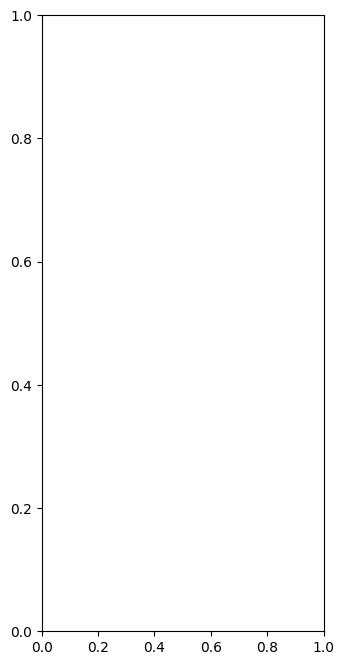

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset and make predictions
for image_batch, label_batch in val_ds:
    # Append true labels for each image in the batch
    y_true.extend(label_batch.numpy())

    # Compute predictions for each image in the batch
    preds = model.predict(image_batch)
    # Append predicted labels for each image in the batch
    y_pred.extend(np.argmax(preds, axis=-1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None, xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontweight='bold')
plt.ylabel("True Label", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.show()


# Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None, xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontweight='bold')
plt.ylabel("True Label", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.show()

# Update the class_names list to match the number of classes
class_names = ['class_1', 'class_2', 'class_3']

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print the classification report
print(report)

In [ ]:
from sklearn.metrics import classification_report

# Print confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None, xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontweight='bold')
plt.ylabel("True Label", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)

# Print classification report
print(report)

### Saving the Model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/models") + [0]])+1
model.save(f"/content/drive/MyDrive/models{model_version}")

In [ ]:
model.save("/potatoes.h5")